In [1]:
from multiprocessing import Pool, cpu_count
import gc; gc.enable()
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn import *
import sklearn

train = pd.read_csv('../input/train.csv')
train = pd.concat((train, pd.read_csv('../input/train_v2.csv')), axis=0, ignore_index=True).reset_index(drop=True)
test = pd.read_csv('../input/sample_submission_v2.csv')

transactions = pd.read_csv('../input/transactions.csv', usecols=['msno'])
transactions = pd.concat((transactions, pd.read_csv('../input/transactions_v2.csv', usecols=['msno'])), axis=0, ignore_index=True).reset_index(drop=True)
transactions = pd.DataFrame(transactions['msno'].value_counts().reset_index())
transactions.columns = ['msno','trans_count']
train = pd.merge(train, transactions, how='left', on='msno')
test = pd.merge(test, transactions, how='left', on='msno')
transactions = []; print('transaction merge...')

user_logs = pd.read_csv('../input/user_logs_v2.csv', usecols=['msno'])
#user_logs = pd.read_csv('../input/user_logs.csv', usecols=['msno'])
#user_logs = pd.concat((user_logs, pd.read_csv('../input/user_logs_v2.csv', usecols=['msno'])), axis=0, ignore_index=True).reset_index(drop=True)
user_logs = pd.DataFrame(user_logs['msno'].value_counts().reset_index())
user_logs.columns = ['msno','logs_count']
train = pd.merge(train, user_logs, how='left', on='msno')
test = pd.merge(test, user_logs, how='left', on='msno')
user_logs = []; print('user logs merge...')

members = pd.read_csv('../input/members_v3.csv')
train = pd.merge(train, members, how='left', on='msno')
test = pd.merge(test, members, how='left', on='msno')
members = []; print('members merge...') 

C:\Users\romai\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\romai\Miniconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\romai\Miniconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning

transaction merge...
user logs merge...
members merge...


In [2]:
gender = {'male':1, 'female':2}
train['gender'] = train['gender'].map(gender)
test['gender'] = test['gender'].map(gender)

train = train.fillna(0)
test = test.fillna(0)

In [3]:
transactions = pd.read_csv('../input/transactions_v2.csv') #pd.read_csv('../input/transactions.csv')
#transactions = pd.concat((transactions, pd.read_csv('../input/transactions_v2.csv')), axis=0, ignore_index=True).reset_index(drop=True)
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')

train = pd.merge(train, transactions, how='left', on='msno')
test = pd.merge(test, transactions, how='left', on='msno')
transactions=[]

In [4]:
train.head()

,msno,is_churn,trans_count,logs_count,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,2,0.0,18.0,36.0,2.0,9.0,20050406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,23,1.0,10.0,38.0,1.0,9.0,20050407.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,10,0.0,11.0,27.0,2.0,9.0,20051016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,3,5.0,13.0,23.0,2.0,9.0,20051102.0,40.0,30.0,149.0,149.0,1.0,20170327.0,20170426.0,0.0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,9,17.0,3.0,27.0,1.0,9.0,20051228.0,38.0,90.0,477.0,477.0,0.0,20170225.0,20170528.0,0.0


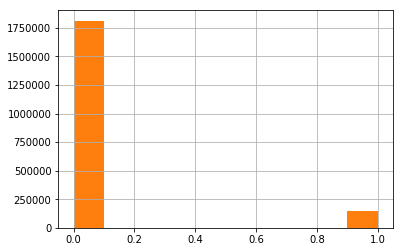

In [6]:
import matplotlib.pyplot as plt
train["is_churn"].hist()
plt.show()

In [ ]:
def transform_df(df):
    df = pd.DataFrame(df)
    df = df.sort_values(by=['date'], ascending=[False])
    df = df.reset_index(drop=True)
    df = df.drop_duplicates(subset=['msno'], keep='first')
    return df

def transform_df2(df):
    df = df.sort_values(by=['date'], ascending=[False])
    df = df.reset_index(drop=True)
    df = df.drop_duplicates(subset=['msno'], keep='first')
    return df

df_iter = pd.read_csv('../input/user_logs.csv', low_memory=False, iterator=True, chunksize=10000000)
last_user_logs = []
i = 0 #~400 Million Records - starting at the end but remove locally if needed
for df in df_iter:
    if i>35:
        if len(df)>0:
            print(df.shape)
            p = Pool(cpu_count())
            df = p.map(transform_df, np.array_split(df, cpu_count()))   
            df = pd.concat(df, axis=0, ignore_index=True).reset_index(drop=True)
            df = transform_df2(df)
            p.close(); p.join()
            last_user_logs.append(df)
            print('...', df.shape)
            df = []
    i+=1
last_user_logs.append(transform_df(pd.read_csv('../input/user_logs_v2.csv')))
last_user_logs = pd.concat(last_user_logs, axis=0, ignore_index=True).reset_index(drop=True)
last_user_logs = transform_df2(last_user_logs)

train = pd.merge(train, last_user_logs, how='left', on='msno')
test = pd.merge(test, last_user_logs, how='left', on='msno')
last_user_logs=[]

In [ ]:
train = train.fillna(0)
test = test.fillna(0)

cols = [c for c in train.columns if c not in ['is_churn','msno']]

In [ ]:
train.to_csv("../output_preprocessed/train_last_transaction.csv", float_format='%.6f', index = False)
test.to_csv("../output_preprocessed/test_last_transaction.csv", float_format='%.6f', index = False)

In [ ]:
def xgb_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'log_loss', metrics.log_loss(labels, preds)

fold = 1
for i in range(fold):
    params = {
        'eta': 0.02, #use 0.002
        'max_depth': 7,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': i,
        'silent': True
    }
    x1, x2, y1, y2 = model_selection.train_test_split(train[cols], train['is_churn'], test_size=0.3, random_state=i)
    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x1, y1), 150,  watchlist, feval=xgb_score, maximize=False, verbose_eval=50, early_stopping_rounds=50) #use 1500
    if i != 0:
        pred += model.predict(xgb.DMatrix(test[cols]), ntree_limit=model.best_ntree_limit)
    else:
        pred = model.predict(xgb.DMatrix(test[cols]), ntree_limit=model.best_ntree_limit)
pred /= fold
test['is_churn'] = pred.clip(0.+1e-15, 1-1e-15)
test[['msno','is_churn']].to_csv('submission.csv', index=False)
#test[['msno','is_churn']].to_csv('submission.csv.gz', index=False, compression='gzip')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=model); plt.show()